In [1]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [2]:
import numpy as np
import os
import astropy
from astropy import units as u
import matplotlib.pyplot as plt

from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore, observatory_locations
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion


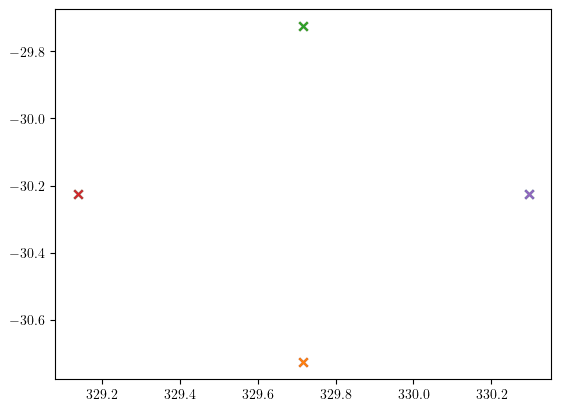

In [3]:
path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
observations = data_store.get_observations(data_store.obs_ids)



ra_pnt, dec_pnt = [], []
for obs in observations:
    ra_pnt.append(obs.obs_info['RA_PNT'])
    dec_pnt.append(obs.obs_info['DEC_PNT'])
    
fig, ax = plt.subplots(1,1)
for i in range(len(observations)):
    plt.scatter(ra_pnt[i], dec_pnt[i], marker = 'x')

In [4]:
pks_pos = SkyCoord(frame = "galactic",l =  "17.74 deg", b= "-52.25 deg")
pks_pos = SkyCoord(obs.obs_info['RA_OBJ'] *u.deg, obs.obs_info['DEC_OBJ']*u.deg)


In [5]:
try:
    models  = Models.read('../standard_model.yml')
except:
    st_model = SkyModel(spatial_model = PointSpatialModel(lon_0 = pks_pos.l.deg *u.deg, lat_0 =  pks_pos.b.deg * u.deg),
                       spectral_model = PowerLawSpectralModel())
    Models(st_model).write("../standard_model.yml")
    models  = Models.read('../standard_model.yml')
    

In [6]:
dataset_public = MapDataset.read('dataset-stacked.fits.gz')
empty = dataset_public.copy()


path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
observations = data_store.get_observations(data_store.obs_ids)


In [7]:
dataset_simulated = MapDataset.read('dataset-simulated-100.0-hr.fits.gz')
emask = dataset_simulated.mask.data.sum(axis=2).sum(axis=1) >0
emask = dataset_simulated.mask.geom.axes[0].center[emask]

## IRF plots

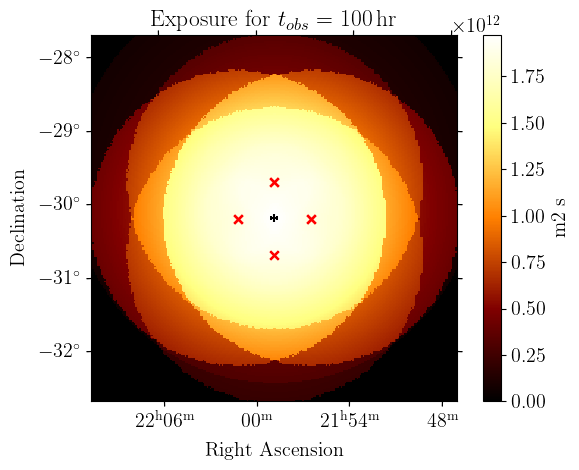

In [8]:
fig = plt.figure( )
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
dataset_simulated.exposure.cutout(dataset_simulated.exposure.geom.center_skydir, 5*u.deg).sum_over_axes().plot(add_cbar = 1);

ax = plt.gca()
fig = plt.gcf()
ax.set_title("Exposure for $t_{obs}$ $ = 100\,$hr", fontsize = 17)
for i in range(len(observations)):
    ax.scatter(ra_pnt[i], dec_pnt[i], marker = 'x', color ='red',
              transform=plt.gca().get_transform("icrs"))
plt.scatter(obs.obs_info['RA_OBJ'], obs.obs_info['DEC_OBJ'] , marker = '+',  color = 'black',
            transform=plt.gca().get_transform("icrs"))
    
plt.tight_layout()
fig.savefig("plots/3-exposure.pdf")
fig.savefig("plots/3-exposure.svg")
fig.savefig("plots/3-exposure.png")

In [9]:
dataset_simulated.psf.containment_radius(0.68, 1*u.TeV)

<Quantity [0.09825] deg>

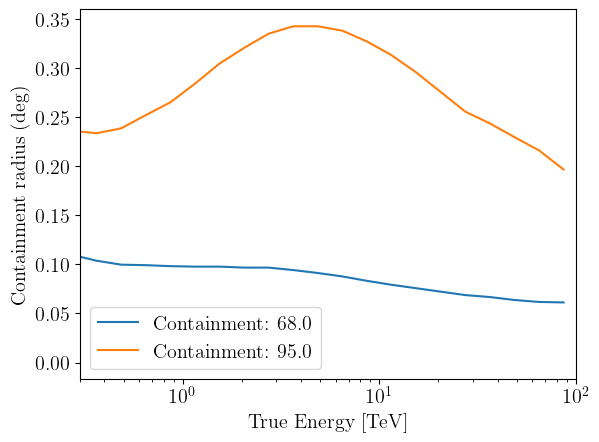

In [10]:
ax = dataset_simulated.psf.plot_containment_radius_vs_energy(  )
fig = plt.gcf()
ax.set_xlim(0.3, 100)
fig.savefig("plots/3-psf.pdf")
fig.savefig("plots/3-psf.svg")
fig.savefig("plots/3-psf.png")

In [54]:
from matplotlib.colors import PowerNorm
from astropy.visualization import quantity_support
def plot_matrix(edisp, ax=None, add_cbar=False, **kwargs):
        """Plot PDF matrix.

        Parameters
        ----------
        ax : `~matplotlib.axes.Axes`, optional
            Axis
        add_cbar : bool
            Add a colorbar to the plot.

        Returns
        -------
        ax : `~matplotlib.axes.Axes`
            Axis
        """
        kwargs.setdefault("cmap", "GnBu")
        norm = PowerNorm(gamma=0.5, vmin=0, vmax=1)
        kwargs.setdefault("norm", norm)

        ax = plt.gca() if ax is None else ax

        energy_axis_true = edisp.axes["energy_true"]
        energy_axis = edisp.axes["energy"]

        with quantity_support():
            caxes = ax.pcolormesh(
                energy_axis_true.edges, energy_axis.edges, edisp.data.T, **kwargs
            )

        if add_cbar:
            label = "Probability density (A.U.)"
            ax.figure.colorbar(caxes, ax=ax, label=label, fraction=0.046, pad=0.04)

        energy_axis_true.format_plot_xaxis(ax=ax)
        energy_axis.format_plot_yaxis(ax=ax)
        return ax

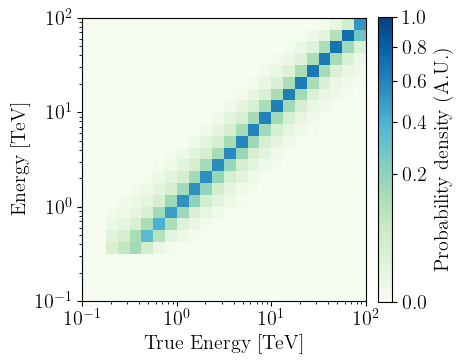

In [56]:
fig, ax = plt.subplots(1,1, figsize= (4,4))

edisp = dataset_simulated.edisp.get_edisp_kernel()
c = plot_matrix(edisp, ax =ax, add_cbar = 1)
#fig.colorbar( ax=ax)
#ax.set_aspect('equal', 'box') # force same scale on both axes
ax.set_aspect(1.0) # force same scale on both axes


fig.savefig("plots/3-edisp.pdf",  bbox_inches='tight')
fig.savefig("plots/3-edisp.svg" ,bbox_inches='tight')
fig.savefig("plots/3-edisp.png",  bbox_inches='tight')


In [12]:
kj

NameError: name 'kj' is not defined

## Creating the models

In [ ]:
import operator
from gammapy.modeling.models import (
    PointSpatialModel,
    PowerLawSpectralModel, 
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    GaussianSpectralModel,
    CompoundSpectralModel,
    SkyModel
)

In [ ]:
spatial_model = PointSpatialModel(lon_0 = pks_pos.ra, 
                                  lat_0 = pks_pos.dec,
                                  frame= 'icrs')

spatial_model.parameters['lon_0'].max = spatial_model.parameters['lon_0'].value + 1
spatial_model.parameters['lon_0'].min = spatial_model.parameters['lon_0'].value - 1
spatial_model.parameters['lat_0'].max = spatial_model.parameters['lat_0'].value + 1
spatial_model.parameters['lat_0'].min = spatial_model.parameters['lat_0'].value - 1

pks_par = dict()
# https://www.aanda.org/articles/aa/pdf/2005/06/aa1853.pdf
# Time-averaged spectrum
factor  = 1 *u.Unit("m-2").to("cm-2")
a = {'value':4.0e-8*factor, 'error':1.9e-8*factor}
pks_par['amplitude'] = a
index = {'value':3.32, 'error':0.06}
pks_par['index'] = index
ecut = {'value':1.4, 'error':0.8}
lambda_ = {'value':1/ecut['value'], 'error': ecut['error']/ (ecut['value'] **2 )}
pks_par['lambda_'] = lambda_

reference = {'value':1, 'error':0.}
pks_par['reference'] = reference
alpha = {'value':1, 'error':0.}
pks_par['alpha'] = alpha

pkscutoff_model = ExpCutoffPowerLawSpectralModel()
for par in pkscutoff_model.parameters:
    par.value = pks_par[par.name]['value']
    par.error = pks_par[par.name]['error']

    
    
crab_par = dict()
# https://arxiv.org/pdf/1509.02902.pdf
a = {'value':1.79e-10, 'error':0.03e-10}
crab_par['amplitude'] = a
alpha = {'value':2.10, 'error':0.04}
crab_par['alpha'] = alpha
beta = {'value':0.24, 'error':0.01}
crab_par['beta'] = beta
reference = {'value':0.521, 'error':0.0}
crab_par['reference'] = reference
logparabola_model = LogParabolaSpectralModel()
for par in logparabola_model.parameters:
    par.value = crab_par[par.name]['value']
    par.error = crab_par[par.name]['error']

scale = 1
pks_reference = 1 *u.TeV
pks_index = 2.3
crab_amplitude = logparabola_model(pks_reference)    *scale

print(crab_amplitude)
powerlaw_model = PowerLawSpectralModel(
    amplitude =crab_amplitude, 
    index = pks_index,
    reference = pks_reference)
pks_lambda = 1/ (30 * u.TeV)
expcutpowerlaw_model = ExpCutoffPowerLawSpectralModel(
    amplitude = crab_amplitude, 
    index = pks_index,
    reference = pks_reference,
    lambda_ = pks_lambda)
pks_mean = 20*u.TeV
pks_sigma = 0.5 *u.TeV
gaussian_model = GaussianSpectralModel(mean  = pks_mean,
                                      sigma = pks_sigma)
gaussian_model = CompoundSpectralModel(model1 = expcutpowerlaw_model, 
                                      model2 = gaussian_model,
                                      operator = operator.add)

powerlaw = SkyModel(spatial_model = spatial_model,
                    spectral_model = powerlaw_model,
                    name = "PL")

expcutpowerlaw = SkyModel(spatial_model = spatial_model,
                    spectral_model = expcutpowerlaw_model,
                    name = "ECPL")

gaussian = SkyModel(spatial_model = spatial_model,
                    spectral_model = gaussian_model,
                    name = "GPL")

pkscutoff = SkyModel(spatial_model = spatial_model,
                       spectral_model = pkscutoff_model,
                    name = "LP")
gaussian.parameters['amplitude_'].frozen = True
#gaussian.parameters['lambda_'].frozen = True
Models([pkscutoff]).write("model-pks-exp.yaml", overwrite = True)


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
colors = ['red', 'forestgreen', 'royalblue','purple']


energy_bounds = [0.3, 100] *u. TeV
energy_power = 2
pkscutoff_model.plot(energy_bounds,label = "LogParabola HESS 2015",
                      energy_power = energy_power,
                      color = colors[0])
pkscutoff_model.plot_error(energy_bounds, energy_power = energy_power,
                             facecolor = colors[0])

powerlaw_model.plot(energy_bounds,
                    label = "$\phi_{PL}$"+f"$(E; \Gamma = {pks_index}$)",
                   energy_power = energy_power, 
                    color = colors[1])

expcutpowerlaw_model.plot(energy_bounds, 
                        label = "$\phi_{ECPL}$"+f"$(E; E_c = {1/pks_lambda.value}\,$TeV)",
                         energy_power = energy_power,
                          color = colors[2])

gaussian_model.plot(energy_bounds, 
                    label = f"$\phi_G(E; \mu = {pks_mean.value}\,$TeV,$ \sigma = {pks_sigma.value}\,$TeV)",
                   energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3])


plt.legend()

plt.ylim(1e-14, 3e-10)
plt.fill_betweenx(ax.get_ylim(), emask[0].value,100, color = 'lightpink', alpha = 0.2)

fig.savefig("plots/2_input_spectra.pdf")

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
colors = ['red', 'forestgreen', 'royalblue','purple', "orange"]


energy_bounds = [0.3, 100] *u. TeV
energy_power = 2
alpha = 0.3
logparabola_model.plot(energy_bounds,label = "Crab - HESS 2015",
                      energy_power = energy_power,
                      color = colors[-1],
                     alpha = alpha)
logparabola_model.plot_error(energy_bounds, energy_power = energy_power,
                             facecolor = colors[-1],
                           alpha = alpha)


#pkscutoff_model.plot(energy_bounds,label = "PKS 2255-304 - LogParabola HESS 2005",
#                      energy_power = energy_power,
#                      color = colors[0],
#                     alpha = alpha)
#pkscutoff_model.plot_error(energy_bounds, energy_power = energy_power,
#                             facecolor = colors[0],
#                           alpha = alpha)

powerlaw_model.plot(energy_bounds,
                    label ="",
                   energy_power = energy_power, 
                    color = colors[1],
                    alpha = alpha)

expcutpowerlaw_model.plot(energy_bounds, 
                        label ="",
                         energy_power = energy_power,
                          color = colors[2],
                          alpha = alpha)

gaussian_model.plot(energy_bounds, 
                    label = "",
                   energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3],
                    alpha = alpha),

models  = [powerlaw_model,expcutpowerlaw_model,gaussian_model]
for m in models:
    m.parameters['amplitude'].value = 0.05 * crab_amplitude.value
    if 'amplitude_' in m.parameters.names:
        m.parameters['amplitude_'].value = 0.05 *  1.0000e-12
alpha = 1
powerlaw_model.plot(energy_bounds,
                    label = "$\phi_{PL}$"+f"$(E; \Gamma = {pks_index}$)",
                   energy_power = energy_power, 
                    color = colors[1],
                   alpha = alpha)

expcutpowerlaw_model.plot(energy_bounds, 
                        label = "$\phi_{ECPL}$"+f"$(E; E_c = {1/pks_lambda.value}\,$TeV)",
                         energy_power = energy_power,
                          color = colors[2],
                         alpha = alpha)

gaussian_model.plot(energy_bounds, 
                    label = f"$\phi_G(E; \mu = {pks_mean.value}\,$TeV, $ \sigma = {pks_sigma.value}\,$TeV)",
                    energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3],
                   alpha = alpha)
for m in models:
    m.parameters['amplitude'].value =  crab_amplitude.value
    if 'amplitude_' in m.parameters.names:
        m.parameters['amplitude_'].value =  1.0000e-12
plt.legend()

plt.ylim(1e-14, 3e-10)
plt.fill_betweenx(ax.get_ylim(), emask[0].value,100, color = 'lightpink', alpha = 0.2)

fig.savefig("plots/2_input_spectra_weak.pdf")

In [ ]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m[0].parameters[p[0]],
                 m[model_name].parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])
            except:
                pass

    plt.tight_layout()

labels = ['simulated', 'recovered pl', 'recovered ecpl']
fmts = ['o','x']
markersize = [6,10]

In [ ]:
dataset_pl = dataset_simulated.copy()
dataset_pl.models = powerlaw.copy()
dataset_ecpl = dataset_simulated.copy()
dataset_ecpl.models = expcutpowerlaw.copy()
dataset_plg = dataset_simulated.copy()
dataset_plg.models = gaussian.copy()


dataset_pl.counts = dataset_pl.npred()
dataset_ecpl.counts = dataset_ecpl.npred()
dataset_plg.counts = dataset_plg.npred()

#dataset_pl.fake(28)
#dataset_ecpl.fake(18)
#dataset_plg.fake(8)



In [ ]:
dataset_pl.write("dataset-simulated-pl.fits.gz", overwrite = True)
dataset_pl.models.write("model-pl.yaml", overwrite = True)
dataset_ecpl.write("dataset-simulated-ecpl.fits.gz", overwrite = True)
dataset_ecpl.models.write("model-ecpl.yaml", overwrite = True)
dataset_plg.write("dataset-simulated-plg.fits.gz", overwrite = True)
dataset_plg.models.write("model-plg.yaml", overwrite = True)


In [ ]:
%%time
fit = Fit()
fit.run([dataset_pl])
fit.run([dataset_ecpl])
fit.run([dataset_plg])

In [ ]:
dataset_pl.plot_residuals(kwargs_spatial={'vmax':0.51,
                                      'vmin':-0.51},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

In [ ]:
models_list = [Models(powerlaw), dataset_pl.models, ]

pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'),]
plot_source_par(0, pars)


In [ ]:
models_list = [Models(expcutpowerlaw), dataset_ecpl.models, ]
pars= [('lon_0', 'lat_0'),('amplitude', 'index'),
                ('lambda_', 'lambda_')]

plot_source_par(0, pars)


In [ ]:
models_list = [Models(gaussian), dataset_plg.models, ]
pars= [('lon_0', 'lat_0'),('amplitude_', 'index'),
                ('lambda_', 'lambda_'), ('mean', 'sigma')]

plot_source_par(0, pars)


In [ ]:
ee = dataset_pl.geoms['geom'].axes[0].center.value
labels = ['PL', 'ECPL', 'G']
datasets = [dataset_pl, dataset_ecpl, dataset_plg]
for i, d in enumerate(datasets):
    plt.plot(ee, 
         (d.counts* d.mask).data.sum(axis=2).sum(axis=1),
            label = labels[i])
plt.loglog()

In [ ]:
stat_sums = []
stat_sumsH0 = []

for d in datasets:
    stat_sums.append(d.stat_sum())

    with d.models.parameters.restore_status():
        d.models.parameters['amplitude'].value = 0
        try:
            d.models.parameters['amplitude_'].value = 0
        except:
            pass
        stat_sumsH0.append(d.stat_sum())
        
        
                     

In [ ]:
print(stat_sums)
print(stat_sumsH0)
print(np.array(stat_sumsH0) - np.array(stat_sums))
print(np.sqrt(np.array(stat_sumsH0) - np.array(stat_sums)))